In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


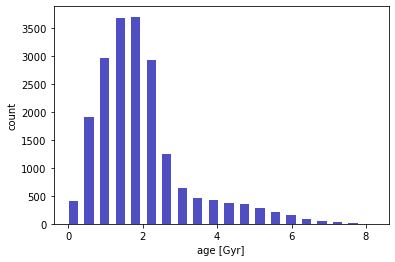

In [7]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

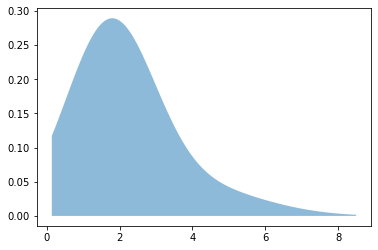

In [8]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.16134894568048957
0.13801577758850292
20000 [2.92333333 2.68094094 0.98419419 ... 2.41347347 0.37403403 2.55556557]


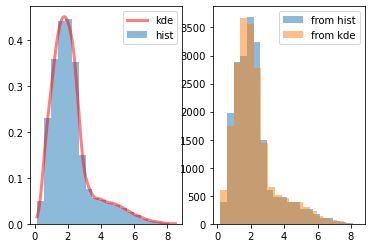

[2.92333333 2.68094094 0.98419419 ... 2.41347347 0.37403403 2.55556557]


In [9]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1_kde)

60000 [ 61.5243563   82.72353482   2.20202558 ... 169.15808216  72.04824646
 107.65784513]
[25419  7449  4687  3370  2591  2101  1788  1623  1395  1255  1144  1108
   942   874   814   816   743   694   632   555]
[  2.0000872   16.89843155  31.79677589  46.69512024  61.59346458
  76.49180893  91.39015327 106.28849761 121.18684196 136.0851863
 150.98353065 165.88187499 180.78021934 195.67856368 210.57690803
 225.47525237 240.37359671 255.27194106 270.1702854  285.06862975
 299.96697409]


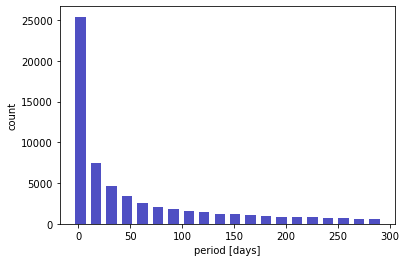

In [10]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[2973 3003 2962 3023 2915 2948 2962 3046 2995 2904 3035 3033 3045 3058
 2968 2981 3047 3094 2989 3019]
[0.69319078 0.94371486 1.19423894 1.44476302 1.6952871  1.94581118
 2.19633526 2.44685934 2.69738342 2.9479075  3.19843158 3.44895566
 3.69947974 3.95000382 4.2005279  4.45105198 4.70157606 4.95210014
 5.20262422 5.4531483  5.70367238]


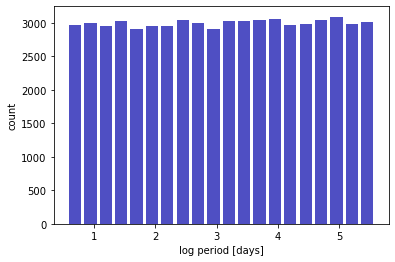

In [11]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Case 2

1.1170311000339714
0.20889447103113198
2000 [0.97331331 0.84332332 0.87087087 ... 0.27945946 0.52824825 0.69611612]


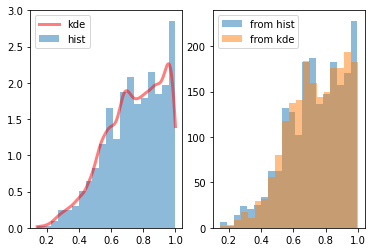

In [12]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr? yes
# going back and using a threshold of 1 Gyr like Berger et al 2020 b/c the proportion of young/old is more realistic
young = berger_kepler.loc[berger_kepler.iso_age <= 1.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 1.].iso_age

stars_age2_young_kde, stars_age2_young_cdf = run_kde(young, 2000)

11000 [  2.02248967   3.31172769 125.20443557 ...  40.79590261 224.98488844
  15.37887899]
[4663 1371  884  597  457  379  330  303  244  248  234  181  179  172
  143  139  121  128  114  113]
[  2.00058602  16.89049797  31.78040992  46.67032186  61.56023381
  76.45014576  91.3400577  106.22996965 121.1198816  136.00979355
 150.89970549 165.78961744 180.67952939 195.56944133 210.45935328
 225.34926523 240.23917718 255.12908912 270.01900107 284.90891302
 299.79882496]


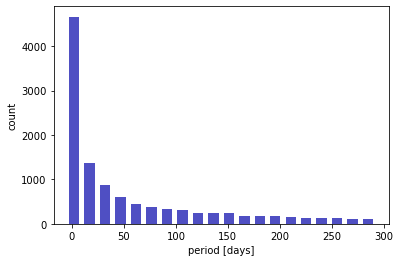

In [13]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.16776569556283707
0.14178034518473398
18000 [1.63146146 1.91598599 1.05492492 ... 1.71382382 2.97172172 2.65724725]


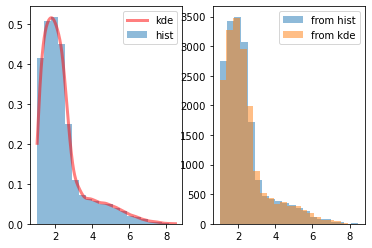

In [14]:
stars_age2_old_kde, stars_age2_old_cdf = run_kde(old, 18000)

27000 [ 2.84062026 14.86774999 38.23077339 ...  3.91682213  2.50302772
  6.16210711]
[11448  3475  2082  1506  1120   948   794   745   612   596   469   444
   371   411   366   372   329   303   307   302]
[  2.00026194  16.89294992  31.7856379   46.67832587  61.57101385
  76.46370183  91.3563898  106.24907778 121.14176576 136.03445373
 150.92714171 165.81982969 180.71251766 195.60520564 210.49789362
 225.39058159 240.28326957 255.17595755 270.06864552 284.9613335
 299.85402148]


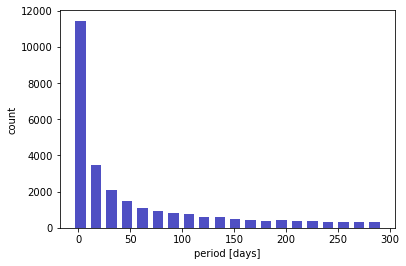

In [15]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

In [ ]:
"""# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution, 2 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()
"""

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [16]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)]))
print(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[2.92333333 2.68094094 0.98419419 ... 4.07678679 1.05941942 1.46062062]


We'll go ahead and use 1 Gyr for now; we'll know from the transit simulation work whether a compact multi rate of 12.6% is consistent with the observed Kepler sample. Tuning this to get it to reproduce Kepler observations will be one of the next few steps anyway.

[ 295 1530 2543 3671 3771 3099 1700  720  512  420  386  343  328  257
  165  109   74   49   23    5]
[0.14602603 0.55199349 0.95796096 1.36392843 1.7698959  2.17586336
 2.58183083 2.9877983  3.39376577 3.79973323 4.2057007  4.61166817
 5.01763564 5.4236031  5.82957057 6.23553804 6.64150551 7.04747297
 7.45344044 7.85940791 8.26537538]


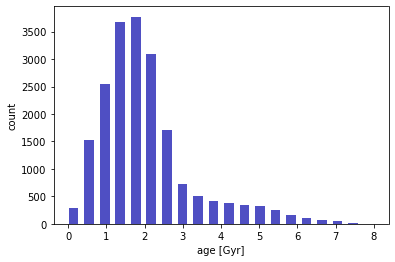

In [17]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars 
# drawn from two piecewise KDEs of the Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young_kde)+list(stars_age2_old_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.16134894568048957
0.13801577758850292
5092
34908


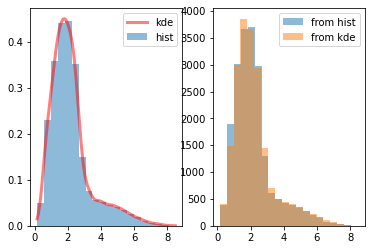

2000 18000


In [18]:
# maybe that was a bad idea to draw two separate piecewise KDEs
# instead, let's use the same KDE from Case 1 and just draw until we get 2000 young and 18000 old stars
def generate_rand_from_pdf_case2(pdf, x_grid, n_young, n_old):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(2*(n_young+n_old))
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    # select 2000 young from Case 1 KDE draw
    case2_young = [i for i in random_from_cdf if i <= 1.]
    print(len(case2_young))
    case2_young = random.sample(case2_young, 2000)
    # else select old
    case2_old = [i for i in random_from_cdf if i > 1.]
    print(len(case2_old))
    case2_old = random.sample(case2_old, 18000)
    return case2_young, case2_old

def run_kde_case2(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde_young, random_from_kde_old = generate_rand_from_pdf_case2(kdepdf, x_grid, 2000, 18000) # generate random data from KDE distribution
    #print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(list(random_from_kde_young)+list(random_from_kde_old), nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde_young, random_from_kde_old

stars_age2_kde_young, stars_age2_kde_old = run_kde_case2(berger_kepler.iso_age, 20000)
print(len(stars_age2_kde_young), len(stars_age2_kde_old))

[ 410 1481 2989 3856 3660 2940 1445  701  495  438  398  331  284  216
  146  104   62   32    9    3]
[0.14       0.55708208 0.97416416 1.39124625 1.80832833 2.22541041
 2.64249249 3.05957457 3.47665666 3.89373874 4.31082082 4.7279029
 5.14498498 5.56206707 5.97914915 6.39623123 6.81331331 7.2303954
 7.64747748 8.06455956 8.48164164]


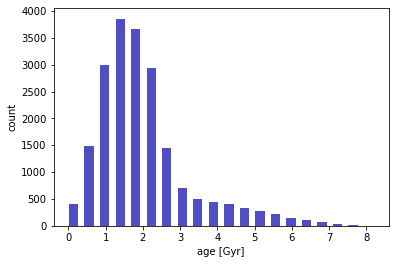

In [19]:
# age histogram for the Case 2 young and old stars, drawn from one continuous KDE fitted to Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_kde_young)+list(stars_age2_kde_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

[ 603 1750 2871 3674 3564 2785 1445  664  518  453  388  384  295  226
  145   96   75   43   17    4]
[0.14       0.55457457 0.96914915 1.38372372 1.7982983  2.21287287
 2.62744745 3.04202202 3.4565966  3.87117117 4.28574575 4.70032032
 5.11489489 5.52946947 5.94404404 6.35861862 6.77319319 7.18776777
 7.60234234 8.01691692 8.43149149]


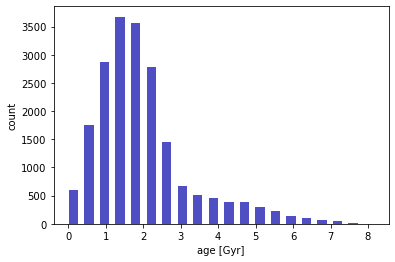

In [20]:
# age histogram for the Case 1 stars
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age1_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [21]:
len([i for i in stars_age1_kde if i <= 1.])

2490

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


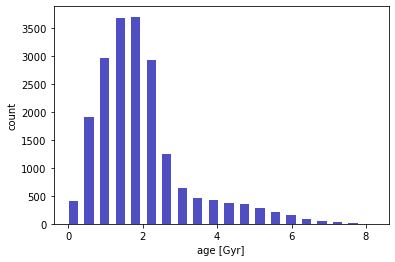

In [22]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

So there's three ways I can go about this. Do I 1) sample from 2 piecewise KDEs fit onto the <1 and >1 parts of the Berger age distribution; 2) sample generously from a single KDE on the Berger age distribution and draw however much I need from the <1 and >1 portions; or 3) just use the KDE from Case 1? Also, should I really be sampling 10%/90% if the true threshold is at 12.6%? If I do that, I'm undersampling for the already smaller young sample. And if I don't do that, then I might as well take option 3, right? <br> <br>

Let's just use the synthetic stars from Case 1 for now and fall back on different sampling proportions if the transit work doesn't look right, as Sarah said.

### Transits

0.38690748364419597
0.13801577758850292
20000 [1.26778979 2.58843443 1.5644985  ... 2.21027628 2.41971772 2.52443844]


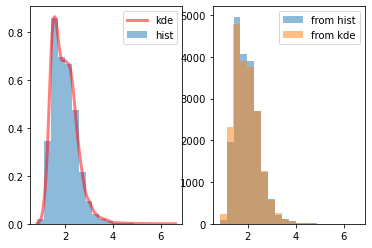

In [23]:
stars_radius_kde, stars_radius_cdf = run_kde(berger_kepler.iso_rad, 20000)

In [24]:
def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * (arg1 / np.sin(np.pi/2 - inc)) # was sin(i) but need to adjust for different index
    return (P / np.pi) * np.arcsin(arg2)

def transit_duration_paw(P, r_star, r_planet, b, a, inc): 
    # https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * arg1 # the only difference is I don't divide by sin(i)
    return (P / np.pi) * np.arcsin(arg2)
    
def transit_duration_normalized_fab(P, r_star, r_planet, b): # Fabrycky 2012 unnamed eqn at the end of pg 8
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    return 2 * arg1 * r_star / (P**(-1./3))
    
def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

def sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star):
    """
    In a loop of stellar radii: draw number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane
    mu_degrees: nobody's perfect
    sigma_degrees: nobody's perfect
    r_planet: radius of the planet
    age_star: age of the star
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, and transit duration
    
    """
    
    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = loguniform.rvs(2, 300, size=num_planets) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = np.random.normal(mu, sigma, num_planets) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 

    # semi-major axes
    planet_a_case2 = day_to_year(planet_per_case2)**(2./3) # calculate semi-major axes based on Kepler's Third Law
    planets_a_case2.append(planet_a_case2) 

    # calculate impact parameters
    b = (planet_a_case2 * np.sin(inclination))/solar_radius_to_au(r_star)
    impact_parameters.append(b)

    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration(day_to_year(planet_per_case2), solar_radius_to_au(r_star), 
                            solar_radius_to_au(r_planet), b, planet_a_case2, inclination)
    #print("tdur: ", tdur)
    #print("tdur_paw: ", transit_duration_paw(planet_per_case2, r_star, r_planet, b, planet_a_case2, inclination))
    #print("tdur_fab: ", transit_duration_normalized_fab(planet_per_case2, r_star, r_planet, b))

    ### calculate xi for the system
    # periods and tdurs already match, so divide them to get normalized tdurs
    tdur_normalized = tdur/(day_to_year(planet_per_case2)**(1./3))

    # make sure I keep info on which tdur_normalized corresponds with which planet
    temp = pd.DataFrame({'period': planet_per_case2, 'tdur_normalized': tdur_normalized})
    temp = temp.dropna()

    # guarantee that xi will always have normalized transit durations of inner planet in numerator 
    temp = temp.sort_values(by='period') 
    #print(temp)
    tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
    #print("combos: ", tdur_normalized_combos)

    for combo in tdur_normalized_combos:
        xi.append(combo[0]/combo[1])
        if age_star <= 1.:
            xi_young.append(combo[0]/combo[1])
        elif age_star > 1:
            xi_old.append(combo[0]/combo[1])

    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])

    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))

In [25]:
# we use stars_age1_kde and planets_per1
# units are AU and year
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

star_index = []
midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
planets_a_case2 = []
star_radius = []
impact_parameters = []
transit_status = []
transit_multiplicities = []
xi = []
xi_old = []
xi_young = []
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2

for i in range(len(stars_radius_kde)):
    # star
    star_index.append(i)
    #r_star = stars_radius_kde[i] # nope
    r_star = solar_radius_to_au(1.) # set to 1 solar radius
    age_star = stars_age1_kde[i]
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
    if age_star <= 1.:
        # young system has 5 or 6 planets
        num_planets = random.choice([5, 6]) 
        
        # simulate transit-related characteristics for 5 or 6 planets
        sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)
        
    elif age_star > 1.:
        # old system has 1 or 2 planets
        num_planets = random.choice([1, 2]) 
        
        # simulate transit-related characteristics for 1 or 2 planets
        sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)
        
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 'semi_major_axes': planets_a_case2,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                 'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                 'transit_multiplicity': transit_multiplicities, 'star_index': star_index}

transits_case2 = pd.DataFrame(transits_dict)
print(transits_case2.head())

   star_ages                                     planet_periods  \
0   2.923333            [252.67167425565518, 8.805937781675809]   
1   2.680941             [22.744546549730284, 5.48408420608601]   
2   0.984194  [4.223636786670838, 3.472232183148471, 9.21767...   
3   2.054064           [19.267638280622315, 2.0205226929496125]   
4   4.068428           [20.557595274469072, 140.92188580041602]   

                                     semi_major_axes  midplane  \
0           [0.7822018089567105, 0.0834574003083272]  0.724885   
1         [0.15710836144000775, 0.06086260269176713]  0.617191   
2  [0.0511374207895912, 0.04487663479913923, 0.08...  1.246171   
3         [0.1406587543143694, 0.031279293289270774]  0.733733   
4          [0.14686872286949912, 0.5299888603484658]  1.236330   

       midplane_degrees                                planet_inclinations  \
0  [24.142508080207406]           [0.7126152550993268, 0.7386331987692798]   
1  [-66.76523522735086]           [0.6352331

In [29]:
"""
for_sarah = transits_case2[['star_index', 'planet_periods', 'planet_inclinations', 'star_radius', 'transit_status']]
print(for_sarah.head())
print(len(for_sarah))
for_sarah = for_sarah.set_index(['star_index']).apply(pd.Series.explode).reset_index()
print(for_sarah.head())
print(len(for_sarah))
for_sarah.to_csv('transit_sim_data.csv',index=False)
"""

   star_index                                     planet_periods  \
0           0            [252.67167425565518, 8.805937781675809]   
1           1             [22.744546549730284, 5.48408420608601]   
2           2  [4.223636786670838, 3.472232183148471, 9.21767...   
3           3           [19.267638280622315, 2.0205226929496125]   
4           4           [20.557595274469072, 140.92188580041602]   

                                 planet_inclinations  star_radius  \
0           [0.7126152550993268, 0.7386331987692798]     1.267790   
1           [0.6352331330865769, 0.6340509823800445]     2.588434   
2  [1.2383657685441432, 1.2619093569384738, 1.224...     1.564498   
3           [0.7710150088864214, 0.7171233813364255]     1.174705   
4            [1.221487588672901, 1.1753340676123654]     3.850901   

       transit_status  
0              [0, 0]  
1              [0, 0]  
2  [0, 0, 0, 0, 0, 0]  
3              [0, 0]  
4              [0, 0]  
20000
   star_index planet_perio

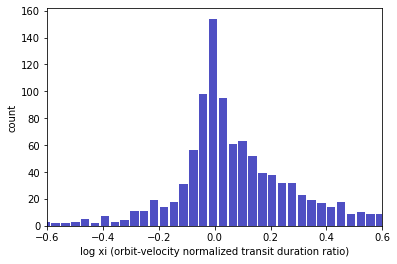

In [43]:
# histogram for xi occurrences...looks about right since I'd expect distribution to favor positive xi
# xi > 0 means inner planets still have lower b and longer transits even w/o considering period
# ie. mutual inclination matters

# should I cut xlim to -0.3, 0.3 before or after binning? before.
xi_hist, xi_bin_edges = np.histogram(np.log(xi), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.6, 0.6])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.show()

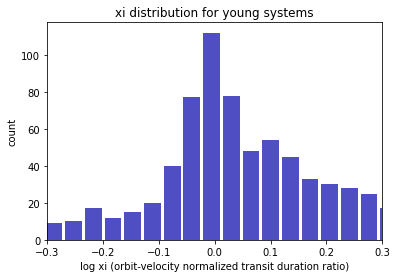

In [44]:
xi_hist, xi_bin_edges = np.histogram(np.log(xi_young), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.3, 0.3])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.title("xi distribution for young systems")
plt.show()

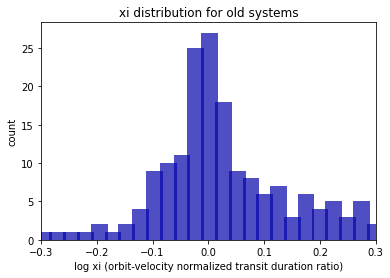

In [45]:
xi_hist, xi_bin_edges = np.histogram(np.log(xi_old), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.3, 0.3])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.title("xi distribution for old systems")
plt.show()

In [46]:
transits_case2.loc[transits_case2.star_ages < 1.].head()

,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,star_radius,impact_parameters,transit_status,transit_multiplicity
1,0.842102,"[7.708293769843994, 12.553709555484375, 8.0220...","[0.07636950031430587, 0.105713185940677, 0.078...",-0.987531,[9.119200209340988],"[-0.9813324929821959, -0.9156467657451451, -0....","[10.30336712592685, 12.148705333824507, 7.3603...",2.152098,"[-6.342885579466382, -8.375674390816663, -6.46...","[0, 0, 0, 0, 0, 0]",0
6,0.967477,"[275.823665970432, 115.53824021126596, 24.1773...","[0.8292817885878115, 0.46426392944887573, 0.16...",-0.220944,[55.16053532443928],"[-0.18618806477283, -0.2038771871810516, -0.22...","[54.88957140678004, 54.918106557943815, 52.825...",2.070649,"[-15.941845337148717, -9.761521054415455, -3.8...","[0, 0, 0, 0, 0]",0
15,0.791952,"[63.77584483078902, 225.80437683474142, 8.0959...","[0.31240544221569577, 0.7257204275357727, 0.07...",-0.141921,[-52.366231746211035],"[-0.10837455576926253, -0.15045366948627475, -...","[-53.974882443769324, -52.805446918781094, -52...",1.913568,"[-3.79712421705627, -12.223392989637151, -1.01...","[0, 0, 0, 0, 0, 0]",0
16,0.934044,"[39.18215260003977, 280.21392436651445, 19.353...","[0.22577367648442032, 0.8380583397104515, 0.14...",0.087692,[-50.57697918800792],"[0.0856084032366196, 0.0979355918304328, 0.094...","[-51.167763638688626, -50.547007560448556, -48...",2.483714,"[1.6713242461585518, 7.094502607054803, 1.1562...","[0, 0, 0, 0, 1]",1
26,0.440901,"[7.171571606235875, 11.5876265097503, 215.9973...","[0.07278200298096187, 0.10021762421537096, 0.7...",-1.230528,[21.955601374766673],"[-1.198706545757113, -1.2112942792295354, -1.3...","[26.33333132542962, 20.377298272651387, 23.089...",1.517956,"[-9.604688836938953, -13.289155932887992, -96....","[0, 0, 0, 0, 0]",0


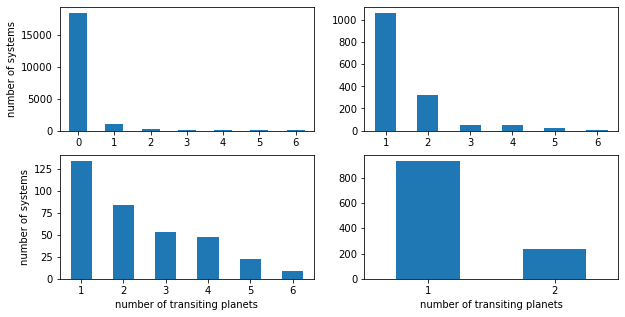

In [47]:
# plot transit multiplicity 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
transits_case2.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')

# systems w/transiters only
ax = fig.add_subplot(2, 2, 2)
transits_case2.loc[transits_case2.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)

# young systems w/transiters
ax = fig.add_subplot(2, 2, 3)
transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')

# old systems w/transiters
ax = fig.add_subplot(2, 2, 4)
transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.xlabel('number of transiting planets')

plt.show()

# young systems with one tranister shouldn't be the majority but should be overrepresented than expected
# this isn't the case...why?

In [48]:
print(len(transits_case2.loc[(transits_case2.star_ages > 1.)])) # total old'uns
print(len(transits_case2.loc[(transits_case2.star_ages < 1.)])) # total young'uns
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])) # old'uns w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])) # young'uns w/transiters

# young systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages < 1.)]))
# old systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages > 1.)]))

# this is weird - we'd expect young systems, which have more close-in planets, to have more transiters on average
# maybe these differences disappear before the 1 Gyr threshold of young vs old? But then we'd expect them to be the same...
# or maybe the loguniform period draws aren't biased enough to get close-in-enough periods for transit effects to kick in. Same problem as above though...



17427
2573
1168
351
0.13641663427905168
0.06702243644918804


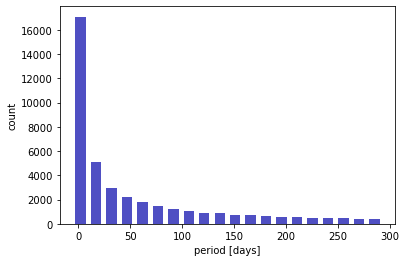

In [107]:
# plot period distribution to double check...yep checks out
per_hist, per_bin_edges = np.histogram(transits_case2.planet_periods.explode(), bins=nbins)
#print(per_hist)
#print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

Case 1: have to further generalize transit_sim(). Will come back to this but it still works as is.

In [31]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 1

midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
planets_a_case1 = []
star_radius = []
impact_parameters = []
transit_status = []
transit_multiplicities = []
xi = []
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2

for r_star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
    num_planets = 3

    # draw 3 planet periods from loguniform distribution
    planet_per_case1 = loguniform.rvs(2, 300, size=num_planets) 
    planets_per_case1.append(planet_per_case1) 

    # incliations for impact parameter formula
    inclination = np.random.normal(mu, sigma, num_planets) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 

    # semi-major axes
    planet_a_case1 = day_to_year(planet_per_case1)**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
    planets_a_case1.append(planet_a_case1) 

    # calculate impact parameters
    b = (planet_a_case1 * np.sin(inclination))/solar_radius_to_au(r_star)
    impact_parameters.append(b)

    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration(day_to_year(planet_per_case1), solar_radius_to_au(r_star),
                            solar_radius_to_au(r_planet), b, planet_a_case1, inclination)
    #print("tdur: ", tdur)
    #print("tdur_paw: ", transit_duration_paw(planet_per_case1, r_star, r_planet, b, planet_a_case1, inclination))
    #print("tdur_fab: ", transit_duration_normalized_fab(planet_per_case1, r_star, r_planet, b))

    ### calculate xi for the system
    # periods and tdurs already match, so divide them to get normalized tdurs
    tdur_normalized = tdur/(day_to_year(planet_per_case1)**(1./3))

    # make sure I keep info on which tdur_normalized corresponds with which planet
    temp = pd.DataFrame({'period': planet_per_case1, 'tdur_normalized': tdur_normalized})
    temp = temp.dropna()

    # guarantee that xi will always have normalized transit durations of inner planet in numerator 
    temp = temp.sort_values(by='period') 
    #print(temp)
    tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
    #print("combos: ", tdur_normalized_combos)

    for combo in tdur_normalized_combos:
        xi.append(combo[0]/combo[1])

    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])
        
    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
        
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1, 'semi_major_axes': planets_a_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                 'impact_parameters': impact_parameters, 'transit_status': transit_status,
                 'transit_multiplicity': transit_multiplicities}

transits_case1 = pd.DataFrame(transits_dict)
print(transits_case1.head())

   star_ages                                     planet_periods  \
0   2.923333  [2.549979111686261, 11.730610966666077, 4.5447...   
1   2.680941  [242.60392543744658, 159.13209237493643, 2.451...   
2   0.984194  [27.505487341595327, 147.2629152892247, 4.0929...   
3   2.054064  [91.36346781845151, 178.64924659336333, 27.093...   
4   4.068428  [8.549292230739892, 6.166409579753915, 5.80285...   

                                     semi_major_axes  midplane  \
0  [0.03652909049116894, 0.10104035544523077, 0.0...  0.925770   
1  [0.7612833410778149, 0.5747155651673241, 0.035...  0.539729   
2  [0.17833120331426017, 0.5457704777279523, 0.05...  1.523383   
3  [0.3970051686068746, 0.6207955139748972, 0.176...  1.153935   
4  [0.08182786477809158, 0.06581163631143042, 0.0... -0.849917   

       midplane_degrees                                planet_inclinations  \
0  [-67.83826530103376]  [0.9137856912697565, 0.9026567847096328, 0.897...   
1  [44.469873862652804]  [0.5642940474563971

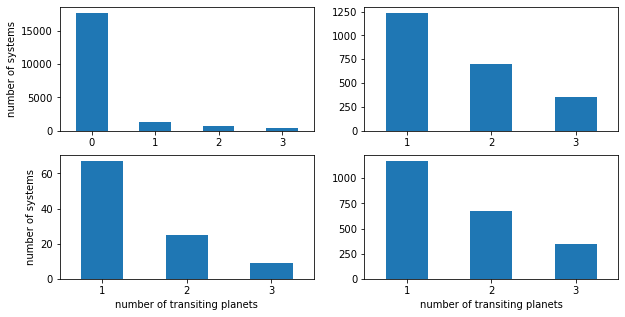

In [32]:
# plot transit multiplicity 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
transits_case1.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')

# systems w/transiters only
ax = fig.add_subplot(2, 2, 2)
transits_case1.loc[transits_case1.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)

# young systems w/transiters
ax = fig.add_subplot(2, 2, 3)
transits_case1.loc[(transits_case1.star_ages < 1.) & (transits_case1.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')

# old systems w/transiters
ax = fig.add_subplot(2, 2, 4)
transits_case1.loc[(transits_case1.star_ages > 1.) & (transits_case1.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.xlabel('number of transiting planets')

plt.show()

# control checks out at least

In [ ]:
# histogram for xi occurrences for Case 1 (control)
xi_hist, xi_bin_edges = np.histogram(np.log(xi), bins=125)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.6, 0.6])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.show()

#### Why do my older systems have a greater proportion of transiters than my young ones? 
Edit: because you mixed up stellar age with stellar radius, ya dummy

40333
2227


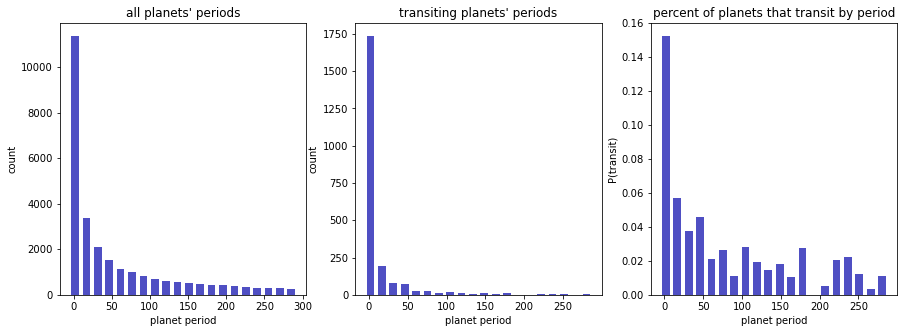

In [49]:
# let's plot P(transit) as a function of period
# proxy: histogram of transits per period bin, divided by histogram of periods

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_period_status = transits_case2[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_status = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_status))

# plot histogram
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("all planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_status.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("transiting planets' periods")

# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of planets that transit by period")
plt.show()

#transits_case2_period_status['ptransit'] = 


26160
1405


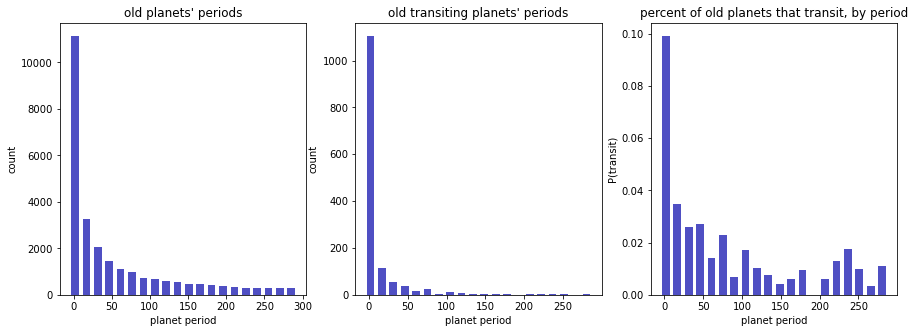

In [50]:
# again for old

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_old = transits_case2.loc[transits_case2.star_ages > 1.]
transits_case2_period_status = transits_case2_old[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_transits_only = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_transits_only))

# percent of old star planets that transit
print(len(transits_case2_period_transits_only)/len(transits_case2_period_status))

### plot histograms
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
per_old_hist, per_old_bin_edges = np.histogram(transits_case2_old.planet_periods.explode(), bins=nbins)
plt.bar(per_old_bin_edges[:-1], per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_transits_only.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old transiting planets' periods")

ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of old planets that transit, by period")
plt.show()



26160
1405
0.05370795107033639


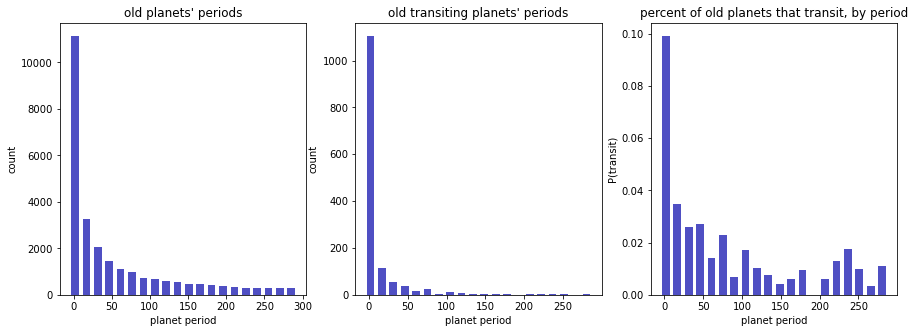

In [54]:
# again for old

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_old = transits_case2.loc[transits_case2.star_ages > 1.]
transits_case2_period_status = transits_case2_old[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_transits_only = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_transits_only))

# percent of old star planets that transit
print(len(transits_case2_period_transits_only)/len(transits_case2_period_status))

### plot histograms
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
per_old_hist, per_old_bin_edges = np.histogram(transits_case2_old.planet_periods.explode(), bins=nbins)
plt.bar(per_old_bin_edges[:-1], per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_transits_only.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old transiting planets' periods")

ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of old planets that transit, by period")
plt.show()

14173
822
0.05799760107246172


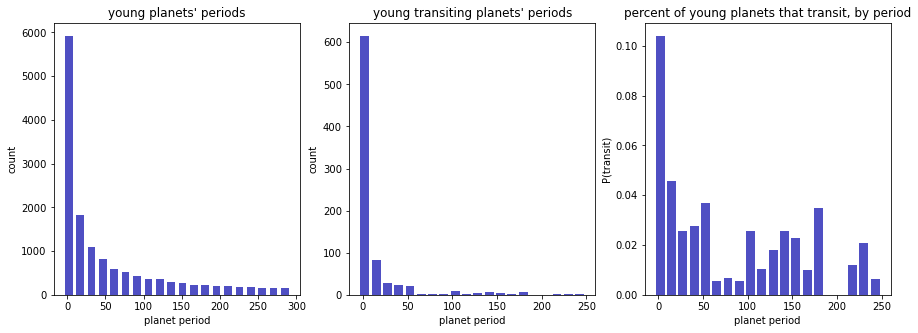

In [56]:
# and for young

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_young = transits_case2.loc[transits_case2.star_ages < 1.]
transits_case2_period_status = transits_case2_young[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_transits_only = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_transits_only))

# percent of young star planets that transit
print(len(transits_case2_period_transits_only)/len(transits_case2_period_status))

### plot histogram
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
per_young_hist, per_young_bin_edges = np.histogram(transits_case2_young.planet_periods.explode(), bins=nbins)
plt.bar(per_young_bin_edges[:-1], per_young_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("young planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_transits_only.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("young transiting planets' periods")

ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_young_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of young planets that transit, by period")
plt.show()


In [ ]:
transits_case2_young[['']]

In [212]:
transits_case2_young['log_period'] = [np.log(t) for t in transits_case2_young.planet_periods]

In [213]:
transits_case2_young.log_period

0        [3.9186166895803636, 2.909889311625487, 3.8895...
13       [1.2568139343497922, 3.962686739422934, 4.4450...
20       [3.1897397898692774, 2.1615046745281936, 4.739...
24       [3.342426989786579, 5.004151015704289, 1.90098...
36       [3.547810091355089, 3.281873697971686, 1.86427...
                               ...                        
19984    [3.6879609490822647, 1.7690685517201719, 2.342...
19988    [5.54496681782125, 5.303778947265764, 5.279326...
19991    [4.398130439397427, 1.7782492271558212, 0.9808...
19995    [2.5572315661225495, 1.5430925571650875, 1.698...
19996    [2.325262531347625, 4.089989764311217, 1.72164...
Name: log_period, Length: 2571, dtype: object

In [140]:
305/14157

0.02154411245320336

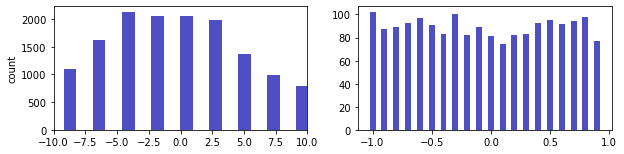

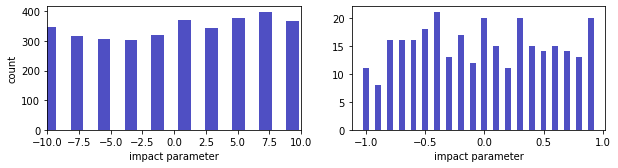

In [169]:
# how about for impact parameter?
# old
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode(), bins=150)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 2)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode().loc[np.abs(transits_case2_old.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.05, color='#0504aa',alpha=0.7)

# young 
ax = fig.add_subplot(2, 2, 3)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode(), bins=1000)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("impact parameter")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 4)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode().loc[np.abs(transits_case2_young.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.05, color='#0504aa',alpha=0.7)
plt.xlabel("impact parameter")

plt.show()

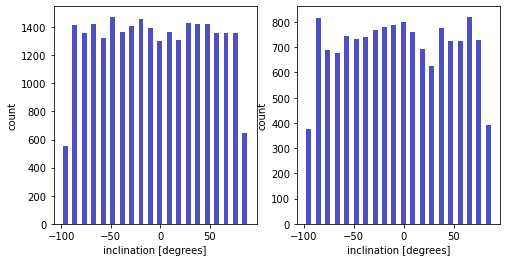

In [195]:
# how about for inclination?
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

plt.show()

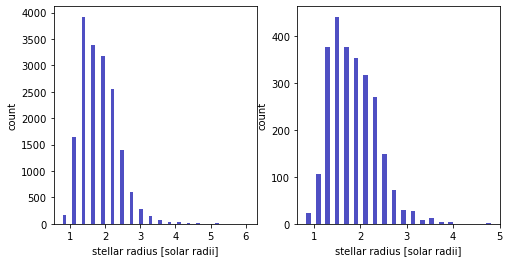

In [184]:
# I'm really running out of ideas now...what's left? R_star? a??
### stellar radius
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.star_radius.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.star_radius.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

plt.show()

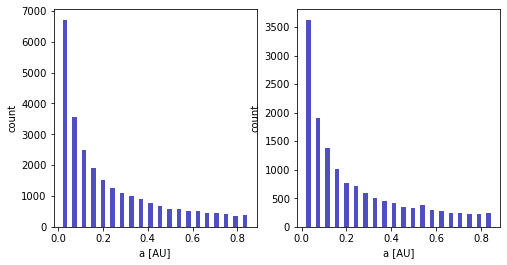

In [188]:
### semi-major axes
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.semi_major_axes.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.semi_major_axes.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

plt.show()